# FAPS and Colony2

Tom Ellis, May 2017

In [2]:
import numpy as np
import pandas as pd
#import os
from faps import *
from time import time
from ipywidgets import FloatProgress
from IPython.display import display
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Simulating genotype datasets

The most sophisticated software for sibship reconstruction at present is Colony 2. To allow direct comparison between FAPS and Colony2, this code generates half-sib arrays of four families each of five offspring, using adult populations between 100 and 2000. I used 50 SNP loci, with a haploid error rate of 0.0015. For each family generated it performs sibship reconstruction using FAPS, and also saves the data to be exported to Colony2. Generating the data is quick.

In [3]:
#=======================#
# Simulation parameters #
#=======================#
nloci    = [10,20,30,40,50,60,70,80]       # number of SNP loci to simulate.
ndads    = [2000] # list of numbers of dads to subset
fsg_size = 5                           # number of full-siblings per family
nreps    = 100                         # number of half sibships to create for each replicate.
mu       = [0.0015] # real haploid genotyping error rate.

In [3]:
# directory to save output to.
fpath1 = "/home/thoel507/Documents/Antirrhinum/colony_fulllikelihood/"
fpath2 = "/home/thoel507/Documents/Antirrhinum/colony_pairwise/"
fpath3 = "/home/thoel507/Documents/Antirrhinum/colony_fpls/"

np.random.seed(1308)
nsims = nreps * len(nloci) * len(mu) * len(ndads) # total number of simulations
data_table      = np.zeros([nsims, 14])           # empty table for summary statistics.

t0 = time()
counter = 0
fp = FloatProgress(min=0, max=nreps) # instantiate the bar
display(fp) # display the bar

for r in range(nreps):
    for n in range(len(ndads)):
        for e in range(len(mu)):
            for l in range(len(nloci)):
                #==============================#
                # generate parents and progeny #
                #==============================#
                # individuals to mate
                dam      = 0
                sires    = range(1,5)
                # generate a base population, and simulate a sibship array.
                allele_freqs = np.random.uniform(0.25,0.5, nloci[l])
                adults = make_parents(ndads[n], allele_freqs) # plus one accounts for the mother
                progeny = make_sibships(adults, dam, sires, fsg_size)

                # Add genotyping errors and dropouts to the genotype data.
                adults = adults.mutations(mu[e])
                progeny = progeny.mutations(mu[e])
                # subset geneotype data for the mothers.
                mothers = adults.subset([0])
                # save the true partition for later.
                true_part = progeny.true_partition()

                #===============#
                # FAPS analysis #
                #===============#
                t1 = time()
                patlik  = paternity_array(progeny, mothers, adults, adults.allele_freqs(), mu[e], selfing_rate=0)
                sc = sibship_clustering(patlik)
                t2 = time()
                # Export to data table
                these_data = np.array([int(counter), int(r), int(nloci[l]), int(ndads[n]), mu[e], # simulation parameters
                                       t2-t1 # time for analysis
                                       ])
                these_data = np.append(these_data, sc.accuracy(progeny, adults))
                data_table[counter] = these_data
                counter += 1
                #====================#
                # Colony2 parameters #
                #====================#
                project_name    = 'n'+str(ndads[n]) + '_l'+ str(nloci[l]) + '_r'+str(r) + '_i'+str(counter) #Dataset name
                seed            = int(np.random.choice(np.arange(1000), 1))  # Seed for Colony
                # dropout and error rates for each locus
                dropout_rates   = sum((adults.geno == -9)[:,0]).astype('float') / adults.size
                error_rates     = np.repeat(mu[e], progeny.nloci)
                parents_present = [1,1]       # prob. of dad/mum included in the candidates
                # Lists of the names of known fathers
                known_dads      = np.repeat('NA', progeny.size)           
                known_mums      = progeny.mothers
                
                # Export data to Colony2 format - full likelihood
                export_to_colony(progeny,                 # offspring genotypes
                                 mothers,                 # maternal genotypes
                                 adults,                  # candidate paternal genotypes
                                 allele_freqs,            # population allele frequencies
                                 fpath1,                  # folder to save data to
                                 project_name,            # project name
                                 project_name,            # output file name prefix
                                 seed,                    # random seed
                                 dropout_rates,           # missing data
                                 error_rates,             # genotyping error rates
                                 known_dads,              # identity of known father
                                 known_mums,              # identity of known mothers
                                 update_af = 0,           # 0/1=Not updating/updating allele frequency
                                 two_sexes = 2,           # 2/1=Dioecious/Monoecious species
                                 inbreeding = 0,          # 0/1=No inbreeding/inbreeding
                                 haplodiploid= 0,         # 0/1=Diploid species/HaploDiploid species
                                 polygamy = [0,0],        # 0/1=Polygamy/Monogamy for males and females
                                 infer_clones = 0,        # 0/1=Clone inference =No/Yes
                                 size_scaling = 1,        # 0/1=Full sibship size scaling =No/Yes
                                 sibship_prior = [0,1,1], # 0,1,2,3=No,weak,medium,strong sibship size prior; mean paternal & maternal sibship size
                                 known_allele_fr = 1,     # 0/1=Unknown/Known population allele frequency
                                 nruns = 1,               # Number of runs
                                 run_length=2,            # Length of run 
                                 monitor_method  = 0,     # 0/1=Monitor method by Iterate#/Time in second 
                                 monitor_interval= 500000,# Monitor interval in Iterate# / in seconds
                                 windows_gui = 0,         # 0/1 running in Windows GUI version? 
                                 analysis_method = 1,     # 0/1/2 pairwise-likelihood score (PLS), full likelihood (FL), or the FL and PLS combined (FPLS) method.
                                 precision = 3,           # 1/2/3=low/medium/high Precision for Fulllikelihood 
                                 parents_present = [1,1], # prob. of dad/mum included in the candidates 
                                 n_incompatibilies=3)
                
                # Export data to Colony2 format - pairwise likelihood
                export_to_colony(progeny,                 # offspring genotypes
                                 mothers,                 # maternal genotypes
                                 adults,                  # candidate paternal genotypes
                                 allele_freqs,            # population allele frequencies
                                 fpath2,                  # folder to save data to
                                 project_name,            # project name
                                 project_name,            # output file name prefix
                                 seed,                    # random seed
                                 dropout_rates,           # missing data
                                 error_rates,             # genotyping error rates
                                 known_dads,              # identity of known father
                                 known_mums,              # identity of known mothers
                                 update_af = 0,           # 0/1=Not updating/updating allele frequency
                                 two_sexes = 2,           # 2/1=Dioecious/Monoecious species
                                 inbreeding = 0,          # 0/1=No inbreeding/inbreeding
                                 haplodiploid= 0,         # 0/1=Diploid species/HaploDiploid species
                                 polygamy = [0,0],        # 0/1=Polygamy/Monogamy for males and females
                                 infer_clones = 0,        # 0/1=Clone inference =No/Yes
                                 size_scaling = 1,        # 0/1=Full sibship size scaling =No/Yes
                                 sibship_prior = [0,1,1], # 0,1,2,3=No,weak,medium,strong sibship size prior; mean paternal & maternal sibship size
                                 known_allele_fr = 1,     # 0/1=Unknown/Known population allele frequency
                                 nruns = 1,               # Number of runs
                                 run_length=2,            # Length of run 
                                 monitor_method  = 0,     # 0/1=Monitor method by Iterate#/Time in second 
                                 monitor_interval= 500000,# Monitor interval in Iterate# / in seconds
                                 windows_gui = 0,         # 0/1 running in Windows GUI version? 
                                 analysis_method = 0,     # 0/1/2 pairwise-likelihood score (PLS), full likelihood (FL), or the FL and PLS combined (FPLS) method.
                                 precision = 3,           # 1/2/3=low/medium/high Precision for Fulllikelihood 
                                 parents_present = [1,1], # prob. of dad/mum included in the candidates 
                                 n_incompatibilies=3)
                
                # Export data to Colony2 format - FPLS hybrid method
                export_to_colony(progeny,                 # offspring genotypes
                                 mothers,                 # maternal genotypes
                                 adults,                  # candidate paternal genotypes
                                 allele_freqs,            # population allele frequencies
                                 fpath3,                  # folder to save data to
                                 project_name,            # project name
                                 project_name,            # output file name prefix
                                 seed,                    # random seed
                                 dropout_rates,           # missing data
                                 error_rates,             # genotyping error rates
                                 known_dads,              # identity of known father
                                 known_mums,              # identity of known mothers
                                 update_af = 0,           # 0/1=Not updating/updating allele frequency
                                 two_sexes = 2,           # 2/1=Dioecious/Monoecious species
                                 inbreeding = 0,          # 0/1=No inbreeding/inbreeding
                                 haplodiploid= 0,         # 0/1=Diploid species/HaploDiploid species
                                 polygamy = [0,0],        # 0/1=Polygamy/Monogamy for males and females
                                 infer_clones = 0,        # 0/1=Clone inference =No/Yes
                                 size_scaling = 1,        # 0/1=Full sibship size scaling =No/Yes
                                 sibship_prior = [0,1,1], # 0,1,2,3=No,weak,medium,strong sibship size prior; mean paternal & maternal sibship size
                                 known_allele_fr = 1,     # 0/1=Unknown/Known population allele frequency
                                 nruns = 1,               # Number of runs
                                 run_length=2,            # Length of run 
                                 monitor_method  = 0,     # 0/1=Monitor method by Iterate#/Time in second 
                                 monitor_interval= 500000,# Monitor interval in Iterate# / in seconds
                                 windows_gui = 0,         # 0/1 running in Windows GUI version? 
                                 analysis_method = 2,     # 0/1/2 pairwise-likelihood score (PLS), full likelihood (FL), or the FL and PLS combined (FPLS) method.
                                 precision = 3,           # 1/2/3=low/medium/high Precision for Fulllikelihood 
                                 parents_present = [1,1], # prob. of dad/mum included in the candidates 
                                 n_incompatibilies=3)                
    fp.value += 1 # signal to increment the progress bar

print "Simulations completed after {} minutes.".format(round((time() - t0) / 60, 2))        

All simulations completed after 32.3 minutes.


Save FAPS data to disk:

In [4]:
# save to disk.         
header=['counter','rep','nloci','ndads','mu','time', 'partition_found','delta_loglik','nfamilies',
         'acc_fs','acc_hs','acc_all','prob_sires','prob_absent']
data_table = pd.DataFrame(data_table, columns=header)
data_table.to_csv('../data_files/colony_faps.csv', index=False)

### Run Colony

Colony can be called for each file using the following command from a UNIX terminal. This took 4h 10min on my Linux machine.

* **Linux:** `for file in *.dat; do ./colony2s.ifort.out IFN:$file; done`

* **Mac:** `for file in *.dat; do ./colony2s.out IFN:$file; done`

This variant also saves the time for each run:

* **Linux** `for file in *.dat; do { time ./colony2s.ifort.out IFN:$file ; } 2> $file.time; done`
* **Mac** `for file in *.dat; do { time ./colony2s.out IFN:$file ; } 2> $file.time; done`

## Accuracy

For each replicate this code locates the relevant Colony2 output file, determines the maximum-likelihood partition structure, and pulls out information about accuracy of sibship reconstruction.

In [31]:
from colony_bestfamily import colony_bestfamily

true_part = np.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]) # the true partition structure for each family
# colony_bestfamily pulls out the .BestFSFamily file for each data set and then computes accuracy for each.
full_acc = colony_bestfamily('/home/thoel507/Documents/Antirrhinum/colony_fulllikelihood/', true_part)
pair_acc = colony_bestfamily('/home/thoel507/Documents/Antirrhinum/colony_pairwise//', true_part)
fpls_acc = colony_bestfamily('/home/thoel507/Documents/Antirrhinum/colony_fpls/', true_part)

# save accuracies to disk.
header='nloci,rep,acc_all,acc_fs,acc_hs,nfamilies'
np.savetxt('../data_files/colony_full.csv', full_acc, delimiter=',', fmt="%5.4f", comments='', header=header)
np.savetxt('../data_files/colony_pair.csv', pair_acc, delimiter=',', fmt="%5.4f", comments='', header=header)
np.savetxt('../data_files/colony_fpls.csv', fpls_acc, delimiter=',', fmt="%5.4f", comments='', header=header)

Reimport the data tables if you are returning to this data set, and get the means for simulations for each level of the number of candidate fathers.

In [32]:
import pandas as pd
# import tables on accuracies
full_acc = pd.read_csv('../data_files/colony_full.csv')
pair_acc = pd.read_csv('../data_files/colony_pair.csv')
fpls_acc = pd.read_csv('../data_files/colony_fpls.csv')
faps_acc = pd.read_csv('../data_files/colony_faps.csv')
# get means for each number of fathers. 
cfull = full_acc.groupby('nloci').mean()
cpair = pair_acc.groupby('nloci').mean()
cfpls = fpls_acc.groupby('nloci').mean()
faps  = faps_acc.groupby('nloci').mean()

To compare the two approaches we can plot the how well they reconstruct relationships between true full- and half- sibs. All three Colony methods reconstruct full-sibling relationships with high accuracy even when loci are few. FAPS shows poor accuracy when there is little genotype information, but is just as accurate when there are 50 or more loci.

Full likelihood, FPLS and FAPS all reconstruct half-sibling relationships with very high accuracy. In contrast, the pairwise method in Colony is very poor at this. The reason for this is that this method tends to group everyone into a single full sibship. As such the high accuracy for full sibling assignment is spurious.

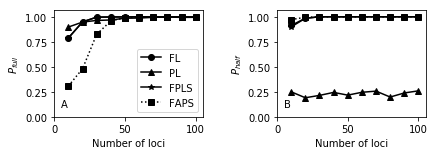

In [34]:
nloci = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

fig = plt.figure(figsize=(16.9/2.54,5/2.54))
fig.subplots_adjust(wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1,2,1)
ax.set_xlim(0,105)
ax.set_ylim(0, 1.07)
ax.set_xlabel('Number of loci')
ax.set_ylabel('$P_{full}$')
ax.plot(nloci, cfull.acc_fs, '-ok', label='FL')
ax.plot(nloci, cpair.acc_fs, '-^k', label='PL')
ax.plot(nloci, cfpls.acc_fs, '-*k', label='FPLS')
ax.plot(nloci, faps.acc_fs, ':sk', label='FAPS')
ax.legend(loc='lower right')
ax.annotate('A', xy=[0,0], xytext=[5,0.1])

bx = fig.add_subplot(1,2,2)
bx.set_xlim(0,105)
bx.set_ylim(0, 1.07)
bx.set_xlabel('Number of loci')
bx.set_ylabel('$P_{half}$')
bx.plot(nloci, cfull.acc_hs, '-ok', label='Full')
bx.plot(nloci, cpair.acc_hs, '-^k', label='Pairwise')
bx.plot(nloci, cfpls.acc_hs, '-*k', label='Pairwise')
bx.plot(nloci, faps.acc_hs, ':sk', label='FAPS')
bx.annotate('B', xy=[0,0], xytext=[5,0.1])

plt.show()
#plt.savefig('../figures/colony2.eps', bbox_inches='tight', pad_inches=0.1)

## Speed

On my machine, analyses for all datasets using the three methods in Colony took the following times:

* **Full likelihood** 671 minutes
* ** FPLS** 465 minutes
* **Pairwise likelihood** 322 minutes

In contrast, FAPS only needed two minutes to create the **G** matrices and perform clustering on the same datasets.
By using FAPS we therefore gain an increase in speed of more than 200-fold relative to the fastest reliable method available in Colony.

In [36]:
faps_acc.time.sum() / 60

2.049888805548238

In separate analyses not shown here, I repeated the simulations changing the number of candidate fathers to 2000. And recorded the following times:

* **Full likelihood** 637 minutes
* ** FPLS** 621 minutes
* **Pairwise likelihood** 569 minutes
* **FAPS** 7 minutes.